# **PACKAGES**

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_DIR = os.getcwd()
if not ROOT_DIR.endswith('sendy_scripts'):
    ROOT_DIR = os.path.dirname(ROOT_DIR)
    
os.chdir(ROOT_DIR)

import xgboost as xgb
from src.processors import Preprocessor
from src.models import XGB_Model, LGB_Model

.

# **DATA LOADING**

In [3]:
train = pd.read_csv("../data/Train.csv")
test = pd.read_csv("../data/Test.csv")
riders = pd.read_csv("../data/Riders.csv")
submission = pd.read_csv("../data/SampleSubmission.csv")

.

# **DATA PREPROCESSING**

In [4]:
train, target = Preprocessor().separate(train)

In [5]:
train = Preprocessor().preprocess_data(train, True)
test = Preprocessor().preprocess_data(test, False)

.

# **MODELIZATION**

## **XGBOOST**

In [33]:
dtrain = XGB_Model().prepare_data(train[list(test.columns)], target)
dtest = XGB_Model().prepare_data(test, None)

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [34]:
xgb_params = {
    'max_depth': 4, 
    'eta': 0.1, 
    'objective': 'reg:squarederror',
    'nthread'  : 4,
    'eval_metric' : "rmse",
}

In [35]:
cv_rmse_xgb = XGB_Model().train_xgb_cv(dtrain, params=xgb_params, nfold=10, num_boost_round=1000)

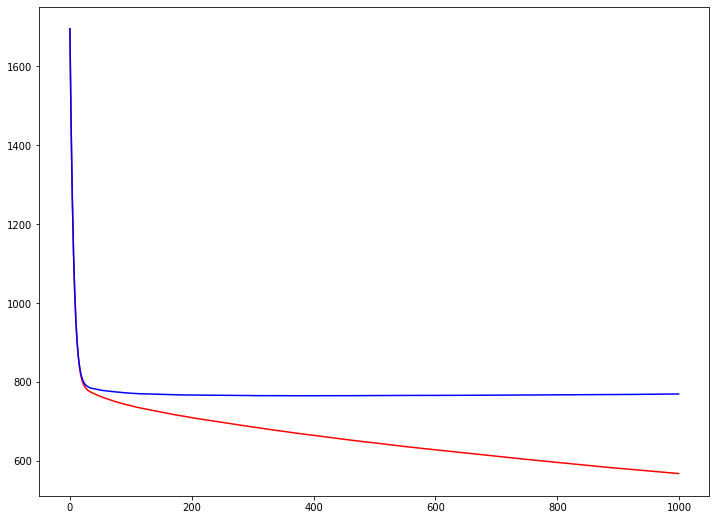

In [37]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] + cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] - cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] + cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] - cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")

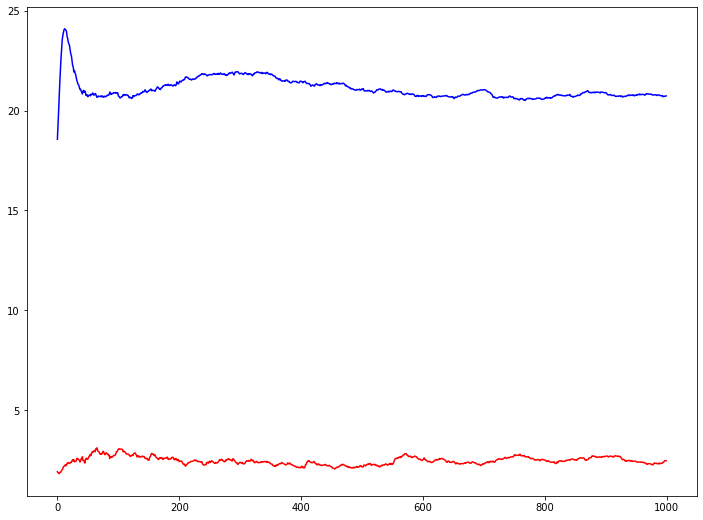

In [38]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-std'], color="red")
plt.plot(cv_rmse_xgb['test-rmse-std'], color="blue")

In [39]:
xgb_model = XGB_Model().train_xgb(dtrain,  params, 1000)

In [40]:
xgb_pred = xgb_model.predict(dtest)

In [63]:
xgb_submission = submission
xgb_submission["Time from Pickup to Arrival"].loc[3:] = np.round(xgb_pred[3:])


/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [64]:
xgb_submission.to_csv("../submissions/XgBoost_1.csv", index=False)

.

## LightGBM

In [12]:
dtrain = LGB_Model().prepare_data(train[list(test.columns)], target)
dtest = LGB_Model().prepare_data(test, None)

In [13]:
lgb_params = {
    'boosting': "gbdt", 
    'learning_rate': 0.1, 
    'objective': 'regression',
    'num_threads'  : 4,
    'metric' : "rmse",
}

In [32]:
cv_rmse_lgb = LGB_Model().train_lgb_cv(dtrain, params=lgb_params, nfold=6, num_boost_round=1000)

In [17]:
for key in cv_rmse_lgb.keys():
    print(key)

rmse-mean
rmse-stdv


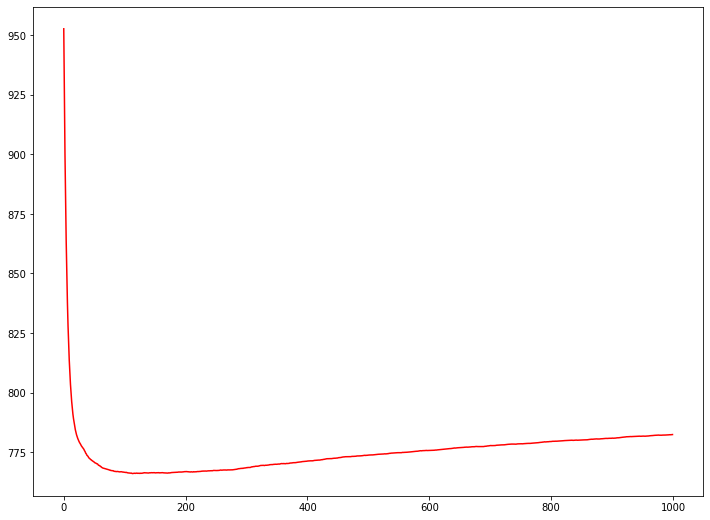

In [33]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_lgb['rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")

In [34]:
np.argmin(cv_rmse_lgb['rmse-mean'])

113

In [37]:
lgb_model = LGB_Model().train_lgb(dtrain,  lgb_params, 113)

In [40]:
lgb_pred = lgb_model.predict(test.drop("Order No", axis=1))

In [42]:
lgb_submission = submission
lgb_submission["Time from Pickup to Arrival"].loc[3:] = np.round(lgb_pred[3:])


/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
lgb_submission.to_csv("../submissions/Lgbm_1.csv", index=False)